<a href="https://colab.research.google.com/github/jaeyoonjeong9024/8-weeks/blob/main/TRANSFORMER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
# 필요 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Conv1D, MaxPooling1D, concatenate,
    GlobalAveragePooling1D, # 💡 Transformer에 필요
    MultiHeadAttention, LayerNormalization, add # 💡 Transformer/ResNet에 필요
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [33]:
# (원본) 파일 로드
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# (원본) 파일 그룹 로드
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    loaded = np.dstack(loaded)
    return loaded

# (원본) 데이터셋 그룹 로드 (train 또는 test)
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # 9개 파일명 생성 (acc 3+3, gyro 3)
    filenames = list()
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # 로드
    X = load_group(filenames, filepath)
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

# (원본) 전체 데이터셋 로드
def load_dataset(prefix=''):
    base_path = prefix + '/content/drive/MyDrive/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/'
    trainX, trainy = load_dataset_group('train', base_path)
    testX, testy = load_dataset_group('test', base_path)
    # 레이블 0-5로 조정 및 원-핫 인코딩
    trainy = trainy - 1
    testy = testy - 1
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print("trainX shape:", trainX.shape, " testX shape:", testX.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [34]:
# 데이터 로드
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

# 학습/검증 데이터 분할
X_train, X_val, y_train_one_hot, y_val_one_hot = train_test_split(
    trainX, trainy_one_hot, test_size=0.2, random_state=100
)

# 모델 파라미터 설정
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = y_train_one_hot.shape[1]

/tmp/ipython-input-4245881589.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-4245881589.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-4245881589.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-4245881589.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


trainX shape: (7352, 128, 9)  testX shape: (2947, 128, 9)


In [35]:
def transformer_encoder_block(input_tensor, num_heads, key_dim, ff_dim, dropout_rate=0.1):
    """Transformer Encoder 블록 (MHA + FFN, ResNet(add) 포함)"""

    # 1. Multi-Head Attention (MHA)
    mha = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
    attn_output = mha(query=input_tensor, value=input_tensor, key=input_tensor)

    # 💡 ResNet (Skip Connection) 1
    skip_1 = add([input_tensor, attn_output])
    norm_1 = LayerNormalization(epsilon=1e-6)(skip_1)

    # 2. Feed-Forward Network (FFN)
    ffn = Sequential(
        [Dense(ff_dim, activation="relu"), Dense(input_tensor.shape[-1])]
    )
    ffn_output = ffn(norm_1)

    # 💡 ResNet (Skip Connection) 2
    skip_2 = add([norm_1, ffn_output])
    norm_2 = LayerNormalization(epsilon=1e-6)(skip_2) # 최종 출력

    return norm_2

In [36]:
## Level_1 (원본과 100% 동일)
inputs1_1= Input(shape=(n_timesteps,n_features))
conv1_1 = Conv1D(filters=128, kernel_size=3, activation='relu')(inputs1_1)
inputs1_2= Input(shape=(n_timesteps,n_features))
conv1_2 = Conv1D(filters=128, kernel_size=5, activation='relu')(inputs1_2)
inputs1_3= Input(shape=(n_timesteps,n_features))
conv1_3 = Conv1D(filters=128, kernel_size=7, activation='relu')(inputs1_3)
inputs1_4= Input(shape=(n_timesteps,n_features))
conv1_4 = Conv1D(filters=128, kernel_size=9, activation='relu')(inputs1_4)
merged_1 = concatenate([conv1_1,conv1_2,conv1_3,conv1_4],axis=1)
pool_1=MaxPooling1D(pool_size=5)(merged_1)

## Level_2 (원본과 100% 동일)
conv2_1 = Conv1D(filters=64, kernel_size=3, activation='relu')(pool_1)
conv2_2 = Conv1D(filters=64, kernel_size=5, activation='relu')(pool_1)
conv2_3 = Conv1D(filters=64, kernel_size=7, activation='relu')(pool_1)
conv2_4 = Conv1D(filters=64, kernel_size=9, activation='relu')(pool_1)
merged_2 = concatenate([conv2_1,conv2_2,conv2_3,conv2_4],axis=1)
pool_2=MaxPooling1D(pool_size=5)(merged_2)

## Level_3 (원본과 100% 동일)
conv3_1 = Conv1D(filters=32, kernel_size=3, activation='relu')(pool_2)
conv3_2 = Conv1D(filters=32, kernel_size=5, activation='relu')(pool_2)
conv3_3 = Conv1D(filters=32, kernel_size=7, activation='relu')(pool_2)
conv3_4 = Conv1D(filters=32, kernel_size=9, activation='relu')(pool_2)
merged_3 = concatenate([conv3_1,conv3_2,conv3_3,conv3_4],axis=1)
pool_3=MaxPooling1D(pool_size=5)(merged_3)
# (참고) pool_3의 shape: (None, 3, 32)

## 💡 (교체) Transformer + ResNet 파트
# (32 채널을 4개 헤드로 분할)
transformer_output = transformer_encoder_block(pool_3, num_heads=4, key_dim=32, ff_dim=64)

# (교체) GlobalAveragePooling1D로 벡터화
pooling = GlobalAveragePooling1D()(transformer_output)

## (교체) Dense Layer
dense = Dense(512, activation='relu')(pooling)
outputs = Dense(n_outputs, activation='softmax')(dense)

## (원본과 동일) 4-입력 구조
transformer_model = Model([inputs1_1, inputs1_2, inputs1_3,inputs1_4], outputs)

In [37]:
transformer_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
transformer_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_13      │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_14      │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_15      │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_60 (Conv1D)  │ (None, 126, 128)  │      3,584 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_61 (Conv1D)  │ (None, 124, 128)  │      5,888 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_62 (Conv1D)  │ (None, 122, 128)  │      8,192 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_63 (Conv1D)  │ (None, 120, 128)  │     10,496 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 492, 128)  │          0 │ conv1d_60[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_61[0][0],  │
│                     │                   │            │ conv1d_62[0][0],  │
│                     │                   │            │ conv1d_63[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_9     │ (None, 98, 128)   │          0 │ concatenate_9[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_64 (Conv1D)  │ (None, 96, 64)    │     24,640 │ max_pooling1d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_65 (Conv1D)  │ (None, 94, 64)    │     41,024 │ max_pooling1d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_66 (Conv1D)  │ (None, 92, 64)    │     57,408 │ max_pooling1d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_67 (Conv1D)  │ (None, 90, 64)    │     73,792 │ max_pooling1d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 372, 64)   │          0 │ conv1d_64[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_65[0][0],  │
│                     │                   │            │ conv1d_66[0][0],  │
│                     │                   │            │ conv1d_67[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_10    │ (None, 74, 64)    │          0 │ concatenate_10[0… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_68 (Conv1D)  │ (None, 72, 32)    │      6,176 │ max_pooling1d_10… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_69 (Conv1D)  │ (None, 70, 32)    │     10,272 │ max_pooling1d_10… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_70 (Conv1D)  │ (None, 68, 32)    │     14,368 │ max_pooling1d_10

 Total params: 315,398 (1.20 MB)

 Trainable params: 315,398 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
print("CNN-Transformer (4-Input) 모델 학습 시작...")

model_history = transformer_model.fit(
    x=[X_train, X_train, X_train, X_train], # 💡 (원본 방식 유지)
    y=y_train_one_hot,
    epochs=30,
    batch_size=32,
    validation_data=([X_val, X_val, X_val, X_val], y_val_one_hot)
)

print("학습 완료.")

CNN-Transformer (4-Input) 모델 학습 시작...
Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 50s 227ms/step - accuracy: 0.6754 - loss: 0.7513 - val_accuracy: 0.9415 - val_loss: 0.1490
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 38s 208ms/step - accuracy: 0.9480 - loss: 0.1286 - val_accuracy: 0.9402 - val_loss: 0.1356
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 41s 208ms/step - accuracy: 0.9569 - loss: 0.1108 - val_accuracy: 0.9517 - val_loss: 0.1081
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 41s 207ms/step - accuracy: 0.9580 - loss: 0.1029 - val_accuracy: 0.9538 - val_loss: 0.1077
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 41s 209ms/step - accuracy: 0.9572 - loss: 0.1024 - val_accuracy: 0.9545 - val_loss: 0.1016
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 40s 215ms/step - accuracy: 0.9545 - loss: 0.1142 - val_accuracy: 0.9538 - val_loss: 0.1257
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 41s 216ms/step - accuracy: 0.9591 - loss: 0.1062 - val_accuracy: 0.9585 - val_loss: 0.1010
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 40s 2

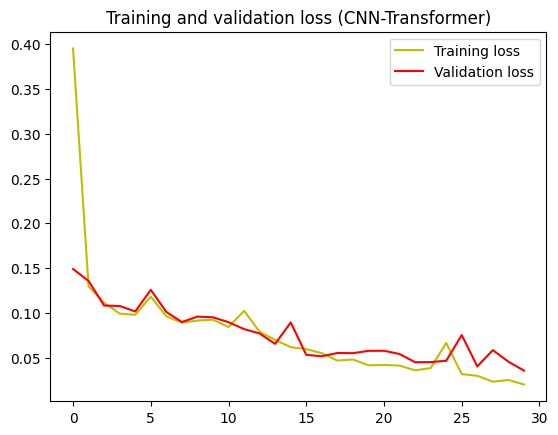

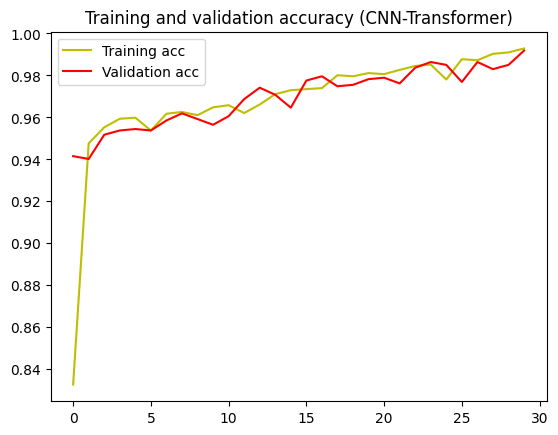

In [39]:
# 손실(Loss) 그래프
plt.plot(model_history.history['loss'], 'y', label='Training loss')
plt.plot(model_history.history['val_loss'], 'r', label='Validation loss')
plt.title('Training and validation loss (CNN-Transformer)')
plt.legend()
plt.show()

# 정확도(Accuracy) 그래프
plt.plot(model_history.history['accuracy'], 'y', label='Training acc')
plt.plot(model_history.history['val_accuracy'], 'r', label='Validation acc')
plt.title('Training and validation accuracy (CNN-Transformer)')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step
--- Confusion Matrix ---
[[471   0  25   0   0   0]
 [ 10 424  34   3   0   0]
 [  0   0 420   0   0   0]
 [  0   2   0 399  90   0]
 [  1   2   2  25 502   0]
 [  0  27   0   0   0 510]]

--- Accuracy Score ---
0.9250084832032576

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       496
           1       0.93      0.90      0.92       471
           2       0.87      1.00      0.93       420
           3       0.93      0.81      0.87       491
           4       0.85      0.94      0.89       532
           5       1.00      0.95      0.97       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.92      2947
weighted avg       0.93      0.93      0.92      2947



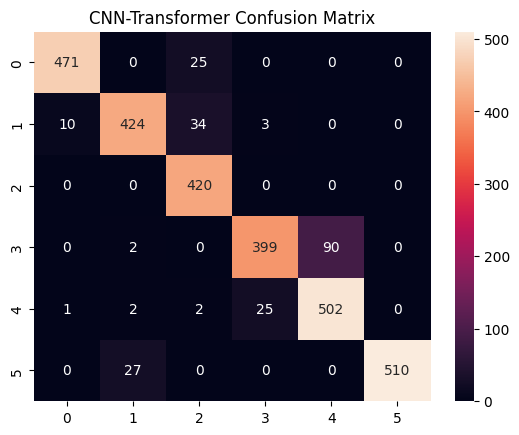

In [40]:
# 예측
pred_transformer = transformer_model.predict([testX, testX, testX, testX]) # 💡 (원본 방식 유지)
pred_classes = np.argmax(pred_transformer, axis=-1)

# 평가
cm = confusion_matrix(testy, pred_classes)
print("--- Confusion Matrix ---")
print(cm)
print("\n--- Accuracy Score ---")
print(accuracy_score(testy, pred_classes))
print("\n--- Classification Report ---")
print(classification_report(testy, pred_classes))

# Heatmap
sns.heatmap(cm, annot=True, fmt='d')
plt.title('CNN-Transformer Confusion Matrix')
plt.show()